# import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create spark session

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [43]:
spark

# Load Data

In [3]:
df_sparkify = spark.read.json('mini_sparkify_event_data.json')
print(df_sparkify.count())
df_sparkify.printSchema()

286500
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df_sparkify.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [5]:
df_sparkify.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [6]:
df_sparkify.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161377|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



# Data Cleaning

In [7]:
# Check for NA values in spark
import pyspark.sql.functions as F
count_na_cols=[F.count(F.when(F.isnan(c),c)).alias(c) for c in df_sparkify.columns]
df_sparkify.select(count_na_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Check for null values in spark
count_null_values=[F.count(F.when(F.isnull(c),c)).alias(c) for c in df_sparkify.columns]
df_sparkify.select(count_null_values).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [9]:
# Filtering values in spark
df_sparkify.filter(F.col('artist').isNull()).toPandas().count()

artist               0
auth             58392
firstName        50046
gender           50046
itemInSession    58392
lastName         50046
length               0
level            58392
location         50046
method           58392
page             58392
registration     50046
sessionId        58392
song                 0
status           58392
ts               58392
userAgent        50046
userId           58392
dtype: int64

In [10]:
#Check for Empty values in spark
df_sparkify.select([F.count(F.when(F.col(c)=="",c)).alias(c) for c in df_sparkify.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


In [11]:
df_sparkify.filter(F.col('userId')=='').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,
5,None,Logged Out,None,None,3,None,None,free,None,PUT,Login,None,240,None,307,1538356679000,None,
6,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,100,None,307,1538358102000,None,
7,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,241,None,307,1538360117000,None,
8,None,Logged Out,None,None,14,None,None,free,None,GET,Home,None,187,None,200,1538361527000,None,
9,None,Logged Out,None,None,15,None,None,free,None,PUT,Login,None,187,None,307,1538361528000,None,


In [12]:
df_sparkify.filter(F.col('userId')=='').groupBy('registration','auth').count().toPandas()

,registration,auth,count
0,None,Logged Out,8249
1,None,Guest,97


In [13]:
# drop rows with empty userId
df = df_sparkify.filter(F.col('userId')!='')
df.count()

278154

In [14]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [15]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [16]:
df.toPandas()['page'].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

In [17]:
# Adding a column churn based on page activity of cancellation confirmation
flag_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0,IntegerType())
df = df.withColumn('churn', flag_churn('page'))

In [18]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn']

In [19]:
churned_rate=df.groupBy('userId').agg({'churn':'sum'}).select(F.avg('sum(churn)')).collect()[0]['avg(sum(churn))']
print("churned: {:.2f}%".format(churned_rate * 100))
print(f'''churned:{round(churned_rate*100,2)}%''')

churned: 23.11%
churned:23.11%


In [20]:
df.select(['userId','gender','level','page','status','ts','churn']).show(30)

+------+------+-----+---------------+------+-------------+-----+
|userId|gender|level|           page|status|           ts|churn|
+------+------+-----+---------------+------+-------------+-----+
|    30|     M| paid|       NextSong|   200|1538352117000|    0|
|     9|     M| free|       NextSong|   200|1538352180000|    0|
|    30|     M| paid|       NextSong|   200|1538352394000|    0|
|     9|     M| free|       NextSong|   200|1538352416000|    0|
|    30|     M| paid|       NextSong|   200|1538352676000|    0|
|     9|     M| free|       NextSong|   200|1538352678000|    0|
|     9|     M| free|       NextSong|   200|1538352886000|    0|
|    30|     M| paid|       NextSong|   200|1538352899000|    0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|    0|
|    30|     M| paid|       NextSong|   200|1538353084000|    0|
|     9|     M| free|       NextSong|   200|1538353146000|    0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    0|
|    30|     M| paid|    

In [21]:
# Total number of users churned
df.filter(F.col('churn')==1).toPandas()['churn'].count()

52

In [22]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [23]:
df_phase = df.withColumn("phase", F.sum('churn').over(windowval))
df_churn = df_phase.withColumn("churned", F.max('churn').over(Window.partitionBy("userId")))

In [24]:
df_churn.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|phase|churned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|    0|      0|
|Francesca Battist...|Logged In|

In [25]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churn", "phase", "churned"]).show(20)

+------+------+-----+-----------+------+-------------+-----+-----+-------+
|userId|gender|level|       page|status|           ts|churn|phase|churned|
+------+------+-----+-----------+------+-------------+-----+-----+-------+
|100010|     F| free|   NextSong|   200|1539003534000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539003736000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539003932000|    0|    0|      0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004195000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004511000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004694000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004918000|    0|    0|      0|
|100010|     F| free|Roll Advert|   200|1539004961000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539005157000|    0|    0|      0|
|100010|     F| free|   N

In [26]:
df_churn.filter(F.col('churned')==1).toPandas()[['userId','gender','level','page','status','ts','churn','phase','churned']].head(20)

,userId,gender,level,page,status,ts,churn,phase,churned
0,125,M,free,NextSong,200,1539317144000,0,0,1
1,125,M,free,NextSong,200,1539317481000,0,0,1
2,125,M,free,NextSong,200,1539317711000,0,0,1
3,125,M,free,NextSong,200,1539317914000,0,0,1
4,125,M,free,NextSong,200,1539318124000,0,0,1
5,125,M,free,NextSong,200,1539318515000,0,0,1
6,125,M,free,NextSong,200,1539318728000,0,0,1
7,125,M,free,NextSong,200,1539318906000,0,0,1
8,125,M,free,Roll Advert,200,1539318917000,0,0,1
9,125,M,free,Cancel,307,1539318918000,0,1,1


In [27]:
churned_user_count = df_churn.filter(df_churn["churned"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


# Data Visualization

In [28]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [29]:
gender_wise=df_churn.select(["userId", "gender", "churn"]).withColumn("churned", func_churn_label("churn")).toPandas()

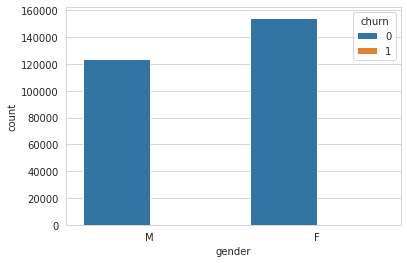

In [30]:
sns.countplot(x="gender", hue="churn", data=gender_wise);

# Joining RDDS

In [40]:
from pyspark import SparkConf
from pyspark import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [41]:
rdd1 =  sc.parallelize([("foo", 1), ("bar", 2), ("baz", 3)])
rdd2 =  sc.parallelize([("foo", 4), ("bar", 5), ("bar", 6)])

In [42]:
sc

<SparkContext master=local[*] appName=Sparkify>

In [45]:
rdd1,rdd2

(ParallelCollectionRDD[164] at parallelize at PythonRDD.scala:195,
 ParallelCollectionRDD[165] at parallelize at PythonRDD.scala:195)

In [55]:
rdd1.count()

3

In [56]:
rdd1.join(rdd2)

PythonRDD[180] at RDD at PythonRDD.scala:53

In [57]:
rdd1.leftOuterJoin(rdd2)

PythonRDD[188] at RDD at PythonRDD.scala:53

In [58]:
rdd1.cartesian(rdd2)

org.apache.spark.api.java.JavaPairRDD@553338c9

In [59]:
cogrouped = rdd1.cogroup(rdd2)

cogrouped.mapValues(lambda x: (list(x[0]), list(x[1]))).collect()

[('bar', ([2], [5, 6])), ('foo', ([1], [4])), ('baz', ([3], []))]

# Joining Spark DataFrames

In [60]:
df1 = spark.createDataFrame(rdd1, ('k', 'v1'))
df2 = spark.createDataFrame(rdd2, ('k', 'v2'))

In [63]:
df1.show()

+---+---+
|  k| v1|
+---+---+
|foo|  1|
|bar|  2|
|baz|  3|
+---+---+



In [64]:
# Register temporary tables to be able to use sqlContext.sql
df1.createTempView('df1')
df2.createTempView('df2')

In [79]:
# inner is a default value so it could be omitted
df1.join(df2, df1.k == df2.k, how='inner') 
x=spark.sql('SELECT * FROM df1 JOIN df2 ON df1.k = df2.k')
x.show()

+---+---+---+---+
|  k| v1|  k| v2|
+---+---+---+---+
|bar|  2|bar|  5|
|bar|  2|bar|  6|
|foo|  1|foo|  4|
+---+---+---+---+



In [82]:
zz=df1.join(df2, df1.k == df2.k, how='left_outer')
zz.show()
# y=spark.sql('SELECT * FROM df1 LEFT OUTER JOIN df2 ON df1.k = df2.k')
# y.show()

+---+---+----+----+
|  k| v1|   k|  v2|
+---+---+----+----+
|bar|  2| bar|   5|
|bar|  2| bar|   6|
|foo|  1| foo|   4|
|baz|  3|null|null|
+---+---+----+----+



In [83]:
df1.crossJoin(df2).show()
# z=spark.sql('SELECT * FROM df1 CROSS JOIN df2')
# z.show()

+---+---+---+---+
|  k| v1|  k| v2|
+---+---+---+---+
|foo|  1|foo|  4|
|foo|  1|bar|  5|
|foo|  1|bar|  6|
|bar|  2|foo|  4|
|bar|  2|bar|  5|
|bar|  2|bar|  6|
|baz|  3|foo|  4|
|baz|  3|bar|  5|
|baz|  3|bar|  6|
+---+---+---+---+



In [78]:
from pyspark.sql.functions import broadcast
p=df1.join(broadcast(df2), df1.k == df2.k)
p.show()

+---+---+---+---+
|  k| v1|  k| v2|
+---+---+---+---+
|foo|  1|foo|  4|
|bar|  2|bar|  6|
|bar|  2|bar|  5|
+---+---+---+---+



In [88]:
# from pyspark import SparkContext
# from pyspark.sql import SparkSession 
# sc = SparkContext.getOrCreate()
# spark = SparkSession(sc)